In [1]:
%%file EulerEq2.m
function  res = EulerEq2(cons,m,capital,cfcn)
% Function EulerEq
%  [res] = EulerEq(kprime)
%
% 目的:
% cを与えたときのオイラー方程式の残差を返す関数.
% main_ti.mから呼び出して使う.

wealth = capital.^m.alpha + (1.-m.delta).*capital;

kprime = wealth - cons;
%% トリック: k'は正の値しか取らない
kprime = max(m.kgrid(1),kprime);

% 次期の政策関数を線形補間: m.nk=21のときは政策関数の形がおかしい
%cnext = interp1(m.kgrid,cfcn,kprime,'linear','extrap');

% 次期の価値関数をスプライン補間
cnext = interp1(m.kgrid,cfcn,kprime,'spline');

%% オイラー方程式
res = (1/cons) - m.beta*(1/cnext)*(m.alpha*kprime.^(m.alpha-1) + (1.-m.delta));
 
return

Created file '/home/takeki/Documents/keizai-seminar/chapter4/Matlab/1_TI_Optimization/EulerEq2.m'.


In [10]:
%%file CRRA.m
function util = CRRA(cons,gamma)
% Function CRRA
%  utility = CRRA( consumption, gamma )
%
% Purpose:
%  Compute CRRA utility function
%
%  Record of revisions:
%     Date     Programmer  Description of change
%  ==========  ==========  =====================
%  10/05/2002  T. Yamada   Original code

if gamma ~= 1;
    util = cons.^(1-gamma)./(1-gamma);
else
    util = log(cons);
end

return

Created file '/home/takeki/Documents/keizai-seminar/chapter4/Matlab/1_TI_Optimization/CRRA.m'.


In [11]:
%%file mu_CRRA.m
function mu = mu_CRRA( cons, gamma )
% Function mu_CRRA
%  marginal_utility = mu_CRRA( consumption, gamma )
%
% Purpose:
%  Compute marginal utility of CRRA-type function
%
%  Record of revisions:
%     Date     Programmer  Description of change
%  ==========  ==========  =====================
%  02/22/2016  T. Yamada   Original code

mu = cons.^-gamma;

return

Created file '/home/takeki/Documents/keizai-seminar/chapter4/Matlab/1_TI_Optimization/mu_CRRA.m'.


In [6]:
%%file nti.m
function [cfcn0 dif] = nti(m)

options = optimoptions('fsolve','Display','none'); % fsolveのオプション(最適化の結果を非表示にする)

% *** 収束の基準 ***
it = 1;          % ループ・カウンター
dif2 = 1.0;      % 政策関数の繰り返し誤差
%options.TolFun = 1.0e-10; % fsolveのオプション(最適化の許容誤差)

%% 計算開始
tic

disp(' ')
disp('-+- Solve a neoclassical growth model with time iteration -+-');
disp(' ')

%% STEP 1(b): 政策関数の初期値を当て推量

% 解析解 (for k'=g(k))
p_true = m.beta*m.alpha*(m.kgrid.^m.alpha);

% 初期値が重要
cfcn0 = m.kgrid;
%cfcn0 = m.css/m.kss*m.kgrid;
%cfcn0 = m.kgrid.^m.alpha - p_true;
%cfcn0 = css*ones(nk,1);
cfcn1 = zeros(m.nk, 1);

% 収束途中の繰り返し計算誤差を保存
% 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
dif = zeros(2,m.maxit);

%% STEP 4: 政策関数を繰り返し計算

while it < m.maxit && dif2 > m.tol

    fprintf('iteration index: %i \n', it);
    fprintf('policy function iteration error: %e\n', dif2);

    for i = 1:m.nk

        capital = m.kgrid(i);
        wealth = capital.^m.alpha + (1.-m.delta).*capital;

        % MATLABの最適化関数(fsolve)を使って各グリッド上の政策関数の値を探す
        % 最適化の初期値は古い政策関数の値
        cons = fsolve(@EulerEq2,cfcn0(i,1),options,m,capital,cfcn0);
        % 最適化の初期値は定常状態の値: これでは解けない
        % cons = fsolve(@EulerEq2,css,options,m,capital,cfcn0);
        cfcn1(i,1) = cons;
        kprime = wealth-cons;
        % グリッドごとに最適化の結果を確認
        %disp([cons capital wealth kprime]);
        %pause

    end

    % 繰り返し計算誤差を確認
    dif2 = max(abs(cfcn1-cfcn0));

    % 収束途中の繰り返し計算誤差を保存
    dif(2,it) = dif2;

    % 政策関数をアップデート
    cfcn0 = cfcn1;

    it = it + 1;

end

Created file '/home/takeki/Documents/keizai-seminar/chapter4/Matlab/1_TI_Optimization/nti.m'.


In [13]:
%m = Models(21,0.5)
%% *** カリブレーション ***
m.beta  = 0.96; % 割引因子
m.gamma = 1.0;  % 相対的危険回避度(異時点間の代替の弾力性の逆数)
m.alpha = 0.40; % 資本分配率
m.delta = 1.00; % 固定資本減耗(0.08)
%delta = 0.08;

% *** 定常状態の値(初期値に使用) ***
m.ykss = (1/m.beta-1+m.delta)/m.alpha;
m.kss = m.ykss^(1/(m.alpha-1));
m.yss = m.ykss*m.kss;
m.css = m.yss-m.delta*m.kss;

m.nk   = 21;    % グリッドの数
m.kmax = 0.5;   % 資本グリッドの最大値
%kmax = 0.4;   % 資本グリッドの最大値(固定資本減耗=1.0の場合、kmax=0.5にすると59行目の初期値では解けない)
%kmax = 10.0; % 資本グリッドの最大値(固定資本減耗=0.08の場合に使用)
m.kmin = 0.05;  % 資本グリッドの最小値 (0にすると生産が出来なくなる)
%========================

%% STEP 1(a): グリッド生成

m.kgrid = linspace(m.kmin, m.kmax, m.nk)';

m.maxit = 1000;    % 繰り返し計算の最大値
m.tol  = 1.0e-5; % 許容誤差(STEP 2)

m


m = 

  struct with fields:

     beta: 0.9600
    gamma: 1
    alpha: 0.4000
    delta: 1
     ykss: 2.6042
      kss: 0.2029
      yss: 0.5283
      css: 0.3254
       nk: 21
     kmax: 0.5000
     kmin: 0.0500
    kgrid: [21x1 double]
    maxit: 1000
      tol: 1.0000e-05



In [8]:
% time iteration
tic;
[cfcn0 dif] = nti(m);
disp(' ');
toc;

 
-+- Solve a neoclassical growth model with time iteration -+-
 
iteration index: 1 
policy function iteration error: 1.000000e+00
iteration index: 2 
policy function iteration error: 9.823124e-02
iteration index: 3 
policy function iteration error: 3.169528e-02
iteration index: 4 
policy function iteration error: 1.135202e-02
iteration index: 5 
policy function iteration error: 5.531453e-03
iteration index: 6 
policy function iteration error: 2.328682e-03
iteration index: 7 
policy function iteration error: 9.272269e-04
iteration index: 8 
policy function iteration error: 3.611994e-04
iteration index: 9 
policy function iteration error: 1.394923e-04
iteration index: 10 
policy function iteration error: 5.369023e-05
iteration index: 11 
policy function iteration error: 2.063218e-05
 
Elapsed time is 0.455894 seconds.


In [15]:
%% 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = m.kgrid.^m.alpha + (1-m.delta)*m.kgrid - cfcn0;

In [16]:
%% 解析的解
p_true = m.beta*m.alpha*(m.kgrid.^m.alpha);

In [17]:
%% オイラー方程式から誤差を測定
% 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる
kgrid_err = linspace(m.kmin, m.kmax, (m.nk-1)*10+1)';
cons = interp1(m.kgrid,cfcn0(:,1),kgrid_err);
LHS  = mu_CRRA(cons, m.gamma);
kp   = kgrid_err.^m.alpha + (1-m.delta)*kgrid_err - cons;
cnext = interp1(m.kgrid, cfcn0(:,1), kp);
rent = m.alpha.*kp.^(m.alpha-1.0) - m.delta;
RHS  = m.beta.*(1.+rent).*mu_CRRA(cnext,m.gamma);
err  = RHS./LHS-1.0;

# plot the results

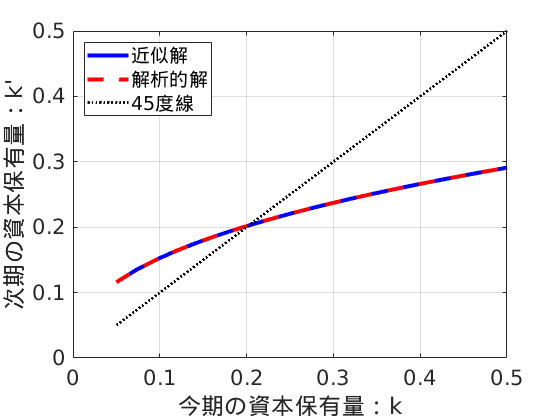

In [18]:
figure;
plot(m.kgrid, pfcn0, '-', 'color', 'blue', 'linewidth', 3); hold('on');
plot(m.kgrid, p_true, '--', 'color', 'red', 'linewidth', 3);
plot(m.kgrid, m.kgrid, ':', 'color', 'black', 'linewidth', 2); hold('off');
xlabel('今期の資本保有量：k', 'Fontsize', 16);
ylabel("次期の資本保有量：k'", 'Fontsize', 16);
xlim([0, m.kmax]);
legend('近似解', '解析的解', '45度線', 'Location', 'NorthWest');
grid on;
set(gca,'Fontsize', 16);

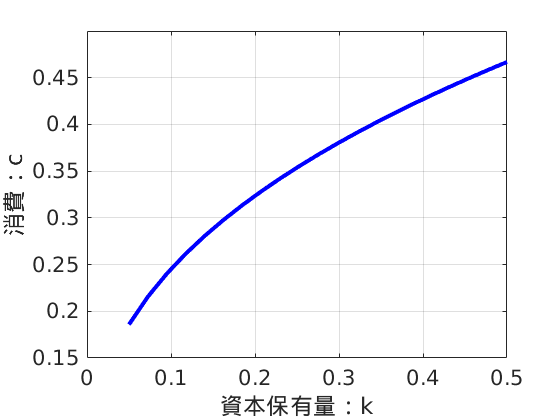

In [10]:
figure;
plot(m.kgrid, cfcn0(:,1), '-', 'color', 'blue', 'linewidth', 3);
xlabel('資本保有量：k', 'Fontsize', 16);
ylabel('消費：c', 'Fontsize', 16);
grid on;
set(gca,'Fontsize', 16);

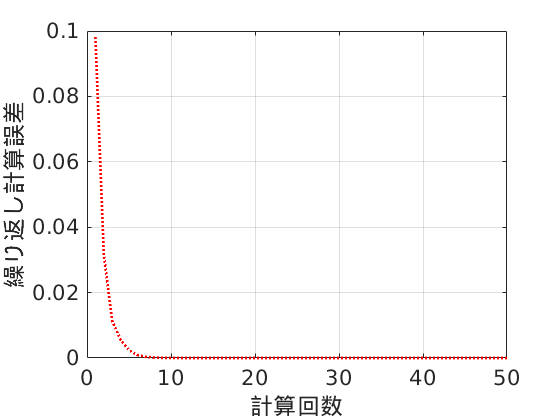

In [19]:
figure;
% plot(iter, dif(1,:), '-', 'color', 'blue', 'linewidth', 2); hold('on');
plot([1:50], dif(2,1:50), ':', 'color', 'red', 'linewidth', 2); hold('off');
xlabel('計算回数', 'Fontsize', 16);
ylabel('繰り返し計算誤差', 'Fontsize', 16);
ylim([0,0.1]);
grid on;
set(gca,'Fontsize', 16);

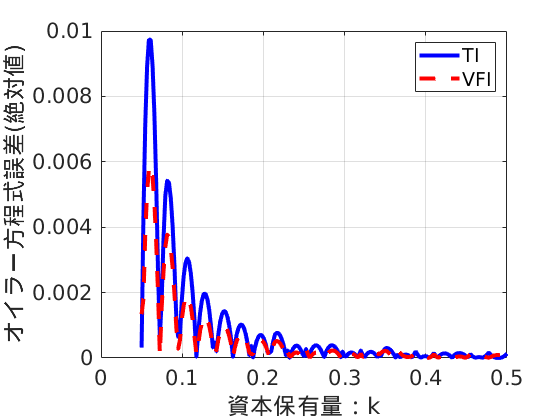

In [20]:
err2 = csvread("err_ndp.csv");
figure;
plot(kgrid_err, abs(err), '-', 'color', 'blue', 'linewidth', 3); hold('on');
plot(kgrid_err, abs(err2), '--', 'color', 'red', 'linewidth', 3); hold('off');
xlabel('資本保有量：k', 'Fontsize', 16);
ylabel('オイラー方程式誤差(絶対値)', 'Fontsize', 16);
legend('TI', 'VFI', 'Location', 'NorthEast');
grid on;
set(gca,'Fontsize', 16);